# Basic image manipulation 

## Utils and image

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_image(im, h=5, **kwargs):
    '''
    Helper function to plot an image.
    im: np.array
    '''
    x, y = im.shape[:2]
    w = (y/x)*h
    plt.figure(figsize=(w,h))
    plt.imshow(im, interpolation="none", **kwargs)

In [3]:
im = np.random.randint(low=0, high=255, size=(6000, 6000, 3))
print(im)

[[[ 68 230 187]
  [ 87 196  17]
  [144 155 246]
  ...
  [ 12 199 170]
  [ 40 172 110]
  [ 44 170 121]]

 [[142  79 134]
  [ 13 179 189]
  [173  73  76]
  ...
  [  5 111 214]
  [228  39  11]
  [209 236 118]]

 [[ 78  24 209]
  [169  74 212]
  [123  90 180]
  ...
  [ 16  36 125]
  [230   2 178]
  [150 125 229]]

 ...

 [[223 151  21]
  [ 30 253 124]
  [107   9 245]
  ...
  [212 229 168]
  [ 14  77 205]
  [161   6 122]]

 [[168  23  73]
  [134  10 221]
  [124 132 168]
  ...
  [152  42 217]
  [ 30 247 180]
  [215 226 246]]

 [[ 16 247  41]
  [232  98  40]
  [214 145 216]
  ...
  [152  92 179]
  [175  15 127]
  [174  27 107]]]


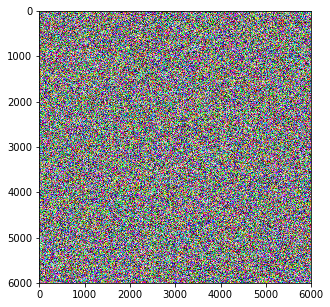

In [4]:
plot_image(im)

## Starting playing with a mask

In [10]:
mask = np.array([ 
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                ])
res = np.sum(im[0:6, 0:6, :]*mask[:,:,np.newaxis], axis=(0,1))
print(res)

[4561 3918 4795]


In [11]:
def apply_mask_once(im, ma, i, j):
    dx, dy = ma.shape
    start_i, end_i = i*dx, (i+1)*dx
    start_j, end_j = j*dy, (j+1)*dy
    indices = (slice(start_i, end_i), slice(start_j, end_j), slice(None, None))
    pixel = np.sum(im[indices]*ma[:, :, np.newaxis], axis=(0, 1))
    return pixel / (ma.size*255)

In [12]:
apply_mask_once(im, mask, 1, 1)

array([0.49183007, 0.42625272, 0.55566449])

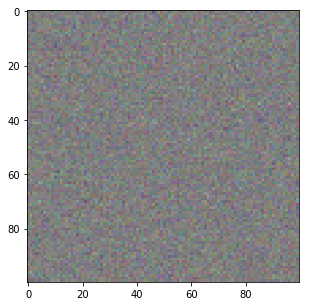

In [13]:
# 6x6
mask = np.ones(shape=(6, 6))
im_comp = np.array([[apply_mask_once(im, mask, i, j) for i in range(0, 100)] for j in range(0, 100)])
plot_image(im_comp)

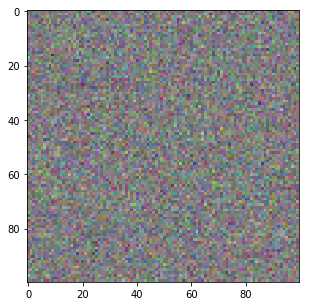

In [14]:
# 3x3
mask = np.ones(shape=(3, 3))
im_comp = np.array([[apply_mask_once(im, mask, i, j) for i in range(0, 100)] for j in range(0, 100)])
plot_image(im_comp)

## Explicit loop approach

In [15]:
def method_loop(image, mask):
    
    # Size of the new image
    dx, dy = mask.shape
    Nx = image.shape[0] // dx
    Ny = image.shape[1] // dy
    
    def reduced_pixel(i, j):
        start_i, end_i = i*dx, (i+1)*dx
        start_j, end_j = j*dy, (j+1)*dy
        indices = (slice(start_i, end_i), slice(start_j, end_j), slice(None, None))
        pixel = np.sum(image[indices]*mask[:, :, np.newaxis], axis=(0, 1))
        return pixel / (mask.size*255)
    
    # Result
    res = np.zeros((Nx, Ny, 3))
    for i in range(0, Nx):
        for j in range(0, Ny):
            res[i, j] = reduced_pixel(i, j)
    
    return res

image = np.random.randint(low=0, high=255, size=(30, 30, 3))
mask = np.ones(shape=(3, 3))
res = method_loop(image, mask)

## (Pseudo) vectorized approach

### Approach with n-dimension mask
Create a mask with the following dimension: `(Nnew, Nold, Nold)`, so one mask per new pixel with a size of the image. But this requires an explicit loop (pseudo-vectorized), and a lot of memory. This is then a very limited approach.

In [16]:
def method_Nmasks(image, mask):

    # Container for the tranformed mask
    Nx = int(image.shape[0]/mask.shape[0])
    Ny = int(image.shape[1]/mask.shape[1])
    trans_mask = np.zeros((Nx, Ny, *image.shape))

    # Filling the transformed mask
    dx, dy = mask.shape
    for i in np.arange(Nx):
        for j in np.arange(Ny):
            start_i, end_i = i*dx, (i+1)*dx
            start_j, end_j = j*dy, (j+1)*dy
            trans_mask[i, j, start_i:end_i, start_j:end_j, :] = mask[:,:, np.newaxis]
            
    # Perform the computation
    convolution = np.sum(image[np.newaxis, ...]*trans_mask, axis=(2, 3))
    image_res = convolution/(mask.size*255)
    
    return image_res

image = np.random.randint(low=0, high=255, size=(30, 30, 3))
mask = np.ones(shape=(6, 6))
res = method_Nmasks(image, mask)

### Approach with `np.as_strided()`

The idea is to first turn the array of dimensio `(Nx, Ny, Ncolor)` into `(Nx_new, Ny_new, Nx_mask, Ny_mask, Ncol)` and then simply multiply and sum over the axis 2 and 3. In order to do this, the most intuitive approach is to use `np.reshape()` function. It does give the proper shape (by construction) but not the proper data. The other approach is quite advance but also quite powerful: `numpy.lib.stride_tricks.as_strided()`. Strides are basically jump in memory to switch from one element to another. It's not yes all clear but this *doesn't duplicate the data but rather view them as a different way*. This is the approach behind the broadcasting. **This is by far the fastest approach**.

In [49]:
def method_strides(image, mask):
    '''Taken (and simplified/adapated) from scikit-image/skimage/util/shape.py'''
    
    from numpy.lib.stride_tricks import as_strided

    # Get the new shape
    m_shape, image_shape = np.array(mask.shape), np.array(image.shape)
    new_shape = tuple(image_shape[:2] // m_shape) + tuple(m_shape) + (image_shape[-1],)
    
    # Get the new strides
    new_strides = tuple(image.strides[:2] * m_shape) + image.strides  # --> quesaco ?!
    
    # Get the new blocked image (Nx_new, Ny_new, Nx_mask, Ny_mask, 3)
    blocked_image = as_strided(image, shape=new_shape, strides=new_strides, writeable=False)
    
    # Apply the mask with the proper broadcasting
    mask_reshaped = mask[np.newaxis, np.newaxis, :, :, np.newaxis]
    return np.mean(blocked_image*mask_reshaped, axis=(2, 3), dtype=np.int)
 
image = np.random.randint(low=0, high=255, size=(30, 30, 3))
mask = np.ones(shape=(3, 3))
res = method_strides(image, mask)

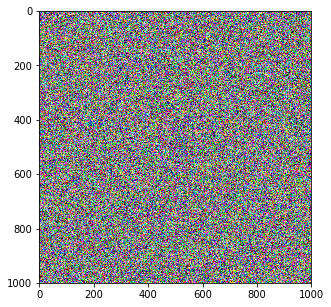

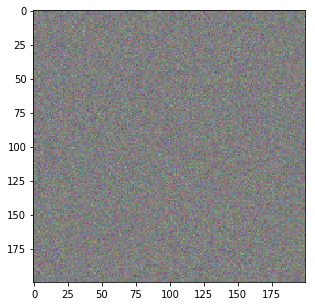

In [50]:
image = np.random.randint(low=0, high=255, size=(1000, 1000, 3))
mask = np.ones(shape=(5, 5))
res = method_strides(image, mask)
plot_image(image)
plot_image(res)

## Using `scipy.convolve2d`

In [20]:
def method_convolve2d(image, mask):
    from scipy import signal
    
    # Performing 2D convolution
    args = {'in2': mask, 'mode': 'same', 'boundary': 'fill', 'fillvalue': 0}
    res = np.array([signal.convolve2d(image[...,i], **args)/(mask.size*255) for i in np.arange(image.shape[2])])
    
    # Channel (color) is first -> moving it as last axis
    res = np.swapaxes(res, 0, 1)
    res = np.swapaxes(res, 2, 1)

    # Take only one pixel over dx, dy to avoid double counting
    dx, dy = mask.shape
    i0, j0 = dx // 2, dy // 2
    return res[i0::dx, j0::dy, :]

image = np.random.randint(low=0, high=255, size=(30, 30, 3))
mask = np.ones(shape=(6, 6))
res = method_convolve2d(image, mask)

## Using `ndimage` librairy

It was quickly tried but not fully understood. It was not pursuied since the stride approach is anyway the most powerful approach.

## Comparing results

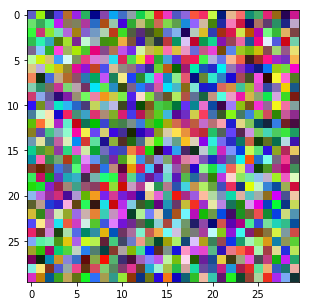

In [21]:
image = np.random.randint(low=0, high=255, size=(30, 30, 3))
mask = np.ones(shape=(5, 5))
plot_image(image)

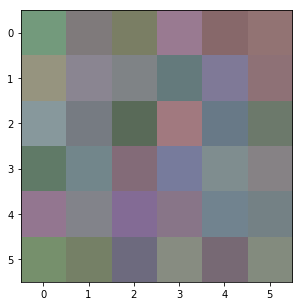

In [22]:
plot_image(method_loop(image, mask))

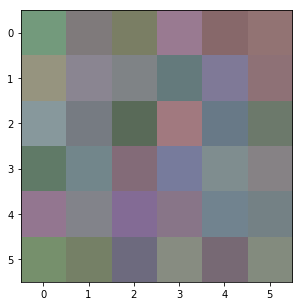

In [23]:
plot_image(method_Nmasks(image, mask))

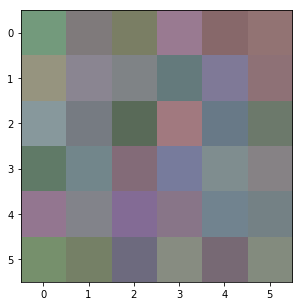

In [24]:
plot_image(method_convolve2d(image, mask))

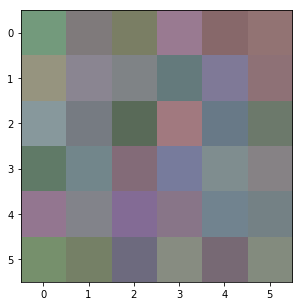

In [25]:
plot_image(method_strides(image, mask))

# Benchmarking

## 100 x 100 = 0.01 Mpixels

In [26]:
image = np.random.randint(low=0, high=255, size=(100, 100, 3))
mask = np.ones(shape=(3, 3))

%timeit method_loop(image, mask)
%timeit method_Nmasks(image, mask)
%timeit method_strides(image, mask)
%timeit method_convolve2d(image, mask)

17.2 ms ± 240 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
483 ms ± 21.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
904 µs ± 21.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.63 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## 1000 x 1000 = 1 Mpixels

In [27]:
image = np.random.randint(low=0, high=255, size=(1000, 1000, 3))
mask = np.ones(shape=(3, 3))

%timeit method_loop(image, mask)
%timeit method_strides(image, mask)
%timeit method_convolve2d(image, mask)

1.74 s ± 13.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
95.3 ms ± 1.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
226 ms ± 4.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 6000 x 6000 = 36 Mpixels

In [29]:
image = np.random.randint(low=0, high=255, size=(6000, 6000, 3))
mask = np.ones(shape=(3, 3))
%timeit method_strides(image, mask)

3.48 s ± 57.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 1 Mega pixel image but different masks

In [30]:
image = np.random.randint(low=0, high=255, size=(1000, 1000, 3))
m10 = np.ones(shape=(10, 10))
m30 = np.ones(shape=(30, 30))
m100 = np.ones(shape=(100, 100))

%timeit method_strides(image, m10)
%timeit method_strides(image, m30)
%timeit method_strides(image, m100)

59.1 ms ± 250 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
48.1 ms ± 365 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
45.8 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Test with a real image

In [3]:
test_im = plt.imread('image_test.jpg')
test_im.shape

(3008, 4008, 3)

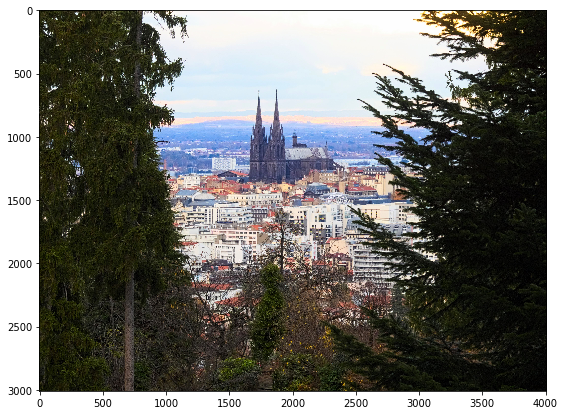

In [44]:
plot_image(test_im, h=7)

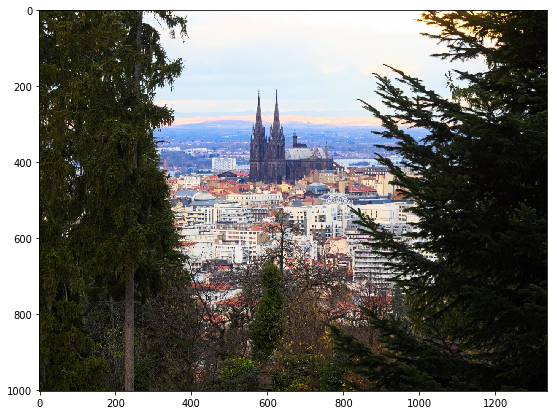

In [45]:
mask = np.ones(shape=(3, 3))
compressed_image = method_strides(test_im, mask)
plot_image(compressed_image, h=7)

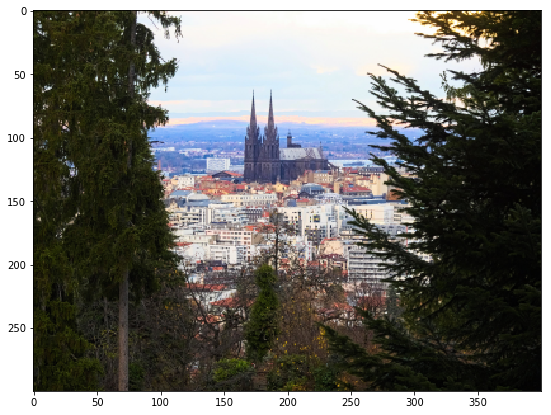

In [46]:
mask = np.ones(shape=(10, 10))
compressed_image = method_strides(test_im, mask)
plot_image(compressed_image, h=7)

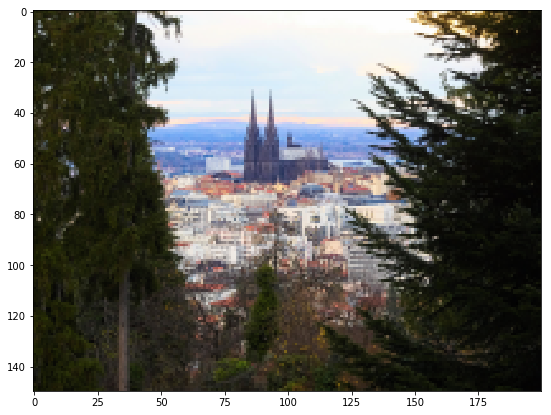

In [47]:
mask = np.ones(shape=(20, 20))
compressed_image = method_strides(test_im, mask)
plot_image(compressed_image, h=7)

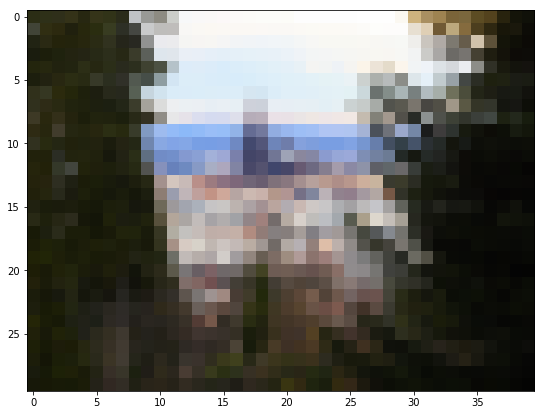

In [48]:
mask = np.ones(shape=(100, 100))
compressed_image = method_strides(test_im, mask)
plot_image(compressed_image, h=7)

## Gray scale,  addition and subtraction

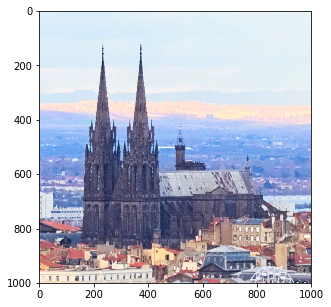

In [6]:
image1 = test_im[500:1500, 1500:2500]
plot_image(image1)

(1000, 1000, 3)


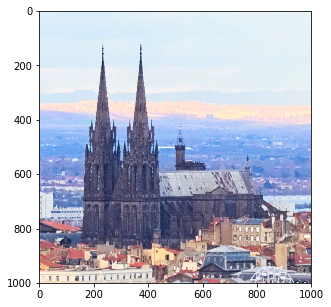

In [34]:
# Gray scale formula: 0.299 R + 0.587 G + 0.114 B 
R, G, B = image1[...,0], image1[...,1], image1[...,2]
# z = np.zeros(R.shape)
# im_test = R
# R[:, : , 0] = R
print(image1.shape)
plot_image(image1)

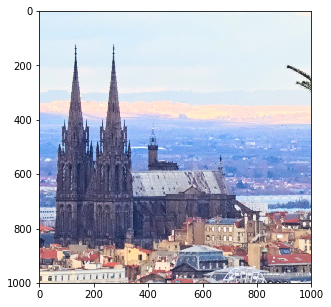

In [9]:
image2 = test_im[500:1500, 1600:2600]
plot_image(image2)

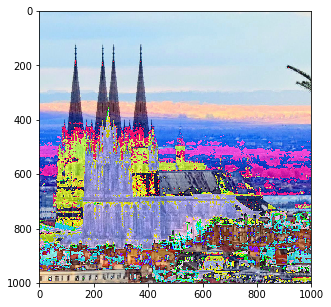

In [17]:
plot_image(image1+image2)

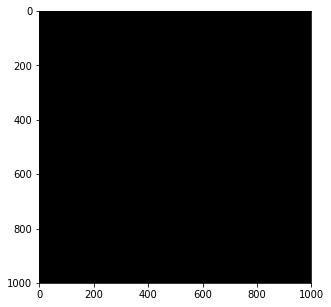

In [19]:
plot_image(image1-image1)